In [1]:
import os
import pandas as pd
import datetime
import dateutil.relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
pd.set_option('plotting.backend', 'matplotlib')

datadir = "drive/MyDrive/Colab Notebooks/9MonthsOut"
files = [f for f in os.listdir(datadir) if f.split(".")[1] == "csv"]
files

['oura_sleep_2023-12-23T16-06-23.csv',
 'oura_daily-sleep_2023-12-23T16-07-00.csv',
 'oura_daily-readiness_2023-12-23T16-07-04.csv',
 'oura_daily-activity_2023-12-23T16-07-07.csv',
 'oura_notes-tags_2023-12-23T16-07-13.csv',
 'oura_bedtime_2023-12-23T16-07-19.csv',
 'oura_smoothed-location_2023-12-23T16-07-23.csv',
 'oura_daily-spo2_2023-12-23T16-07-25.csv']

# Defining time intervals

In [ ]:
birthday = datetime.datetime.strptime("2023-03-21", "%Y-%m-%d")
pregnancy = birthday - dateutil.relativedelta.relativedelta(months=9)
prepregnancy = pregnancy - dateutil.relativedelta.relativedelta(months=9)
parenting = birthday + dateutil.relativedelta.relativedelta(months=9)

prepregnancy, pregnancy, birthday, parenting

(datetime.datetime(2021, 9, 21, 0, 0),
 datetime.datetime(2022, 6, 21, 0, 0),
 datetime.datetime(2023, 3, 21, 0, 0),
 datetime.datetime(2023, 12, 21, 0, 0))

# Daily scores

In [ ]:
def read_and_filter_daily_data(filename: str, score_name: str):
  readiness = pd.read_csv(os.path.join(datadir, filename))
  readiness.day = pd.to_datetime(readiness.day, utc=True).dt.date
  readiness_filtered = readiness.loc[(readiness.day >= prepregnancy.date()) & (readiness.day <= parenting.date()), ["score", "day"]]
  return readiness_filtered.rename({"score": score_name}, axis=1)

In [ ]:
readiness = read_and_filter_daily_data("oura_daily-readiness_2023-12-23T16-07-04.csv", "score")
readiness["var_type"] = "readiness"
sleep = read_and_filter_daily_data("oura_daily-sleep_2023-12-23T16-07-00.csv", "score")
sleep["var_type"] = "sleep"
activity = read_and_filter_daily_data("oura_daily-activity_2023-12-23T16-07-07.csv", "score")
activity["var_type"] = "activity"

sleep_dates = sleep.day.unique()
readiness.shape, sleep.shape, activity.shape

((698, 3), (698, 3), (766, 3))

In [ ]:
all_dailies = pd.concat([readiness, sleep, activity], axis=0)
all_dailies["time_tag"] = ""
all_dailies.loc[all_dailies.day <= pregnancy.date(), "time_tag"] = "prepregnancy"
all_dailies.loc[(all_dailies.day > pregnancy.date()) & (all_dailies.day <= birthday.date()), "time_tag"] = "pregnancy"
all_dailies.loc[all_dailies.day > birthday.date(), "time_tag"] = "parenting"
all_dailies["daynum"] = dates.datestr2num(all_dailies["day"].apply(lambda x: x.strftime('%Y-%m-%d')))
all_dailies.head()

,score,day,var_type,time_tag,daynum
297,74,2021-09-21,readiness,prepregnancy,18891.0
298,78,2021-09-22,readiness,prepregnancy,18892.0
299,83,2021-09-24,readiness,prepregnancy,18894.0
300,77,2021-09-25,readiness,prepregnancy,18895.0
301,75,2021-09-26,readiness,prepregnancy,18896.0


In [ ]:
all_dailies.loc[all_dailies.time_tag == 'parenting', "day"]

796     2023-03-23
797     2023-05-14
798     2023-05-15
799     2023-05-16
800     2023-05-17
           ...    
1082    2023-12-17
1083    2023-12-18
1084    2023-12-19
1085    2023-12-20
1086    2023-12-21
Name: day, Length: 622, dtype: object

In [ ]:
all_dailies.groupby(["var_type", "time_tag"]).mean()

<ipython-input-8-d89825d6a755>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_dailies.groupby(["var_type", "time_tag"]).mean()


score        daynum
var_type  time_tag                             
activity  parenting     89.709821  19599.401786
          pregnancy     80.332103  19301.380074
          prepregnancy  83.616236  19028.284133
readiness parenting     75.216080  19602.005025
          pregnancy     76.808000  19298.388000
          prepregnancy  83.514056  19033.759036
sleep     parenting     74.371859  19602.005025
          pregnancy     87.152000  19298.388000
          prepregnancy  86.345382  19033.759036

In [ ]:
all_dailies_wide = pd.pivot_table(
    data=all_dailies,
    values="score",
    index="day",
    columns="var_type",
    fill_value=np.nan)

all_dailies_wide["activity_weekly"] = all_dailies_wide["activity"].rolling(7, min_periods=1).mean()
all_dailies_wide["sleep_weekly"] = all_dailies_wide["sleep"].rolling(7, min_periods=1).mean()
all_dailies_wide["readiness_weekly"] = all_dailies_wide["readiness"].rolling(7, min_periods=1).mean()
all_dailies_wide["time_tag"] = ""
all_dailies_wide.loc[all_dailies_wide.index <= pregnancy.date(), "time_tag"] = "prepregnancy"
all_dailies_wide.loc[(all_dailies_wide.index > pregnancy.date()) & (all_dailies_wide.index <= birthday.date()), "time_tag"] = "pregnancy"
all_dailies_wide.loc[all_dailies_wide.index > birthday.date(), "time_tag"] = "parenting"
all_dailies_wide

var_type,activity,readiness,sleep,activity_weekly,sleep_weekly,readiness_weekly,time_tag
day,,,,,,,
2021-09-21,88,74.0,78.0,88.000000,78.000000,74.000000,prepregnancy
2021-09-22,95,78.0,77.0,91.500000,77.500000,76.000000,prepregnancy
2021-09-23,95,NaN,NaN,92.666667,77.500000,76.000000,prepregnancy
2021-09-24,90,83.0,82.0,92.000000,79.000000,78.333333,prepregnancy
2021-09-25,89,77.0,75.0,91.400000,78.000000,78.000000,prepregnancy
...,...,...,...,...,...,...,...
2023-12-17,97,85.0,80.0,97.142857,78.285714,84.571429,parenting
2023-12-18,97,82.0,74.0,96.857143,77.857143,84.428571,parenting
2023-12-19,98,82.0,79.0,97.000000,77.714286,83.857143,parenting


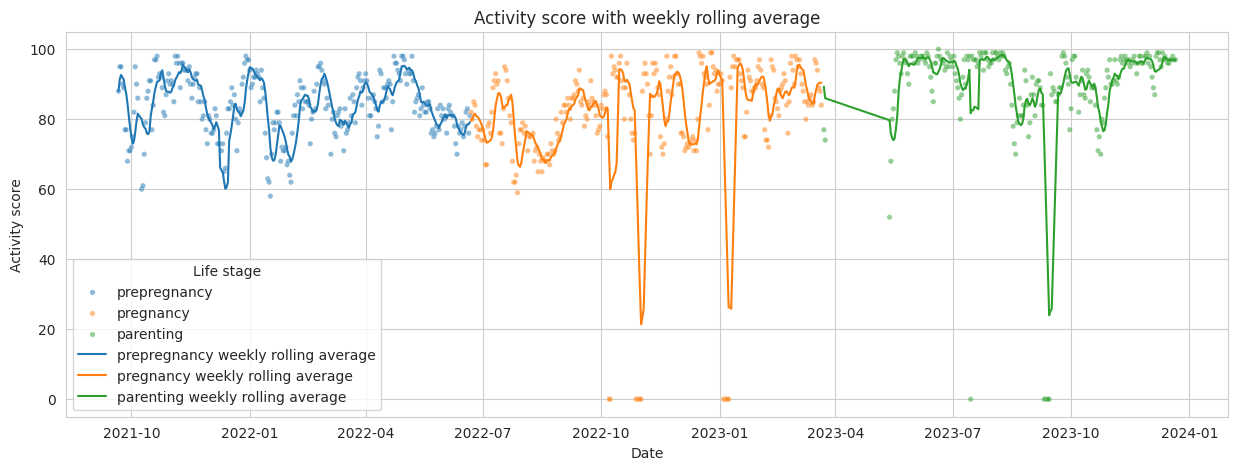

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=all_dailies_wide, x='day', y='activity', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=all_dailies_wide, x='day', y='activity_weekly', hue='time_tag', ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("Activity score")
ax.set_title("Activity score with weekly rolling average")

plt.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

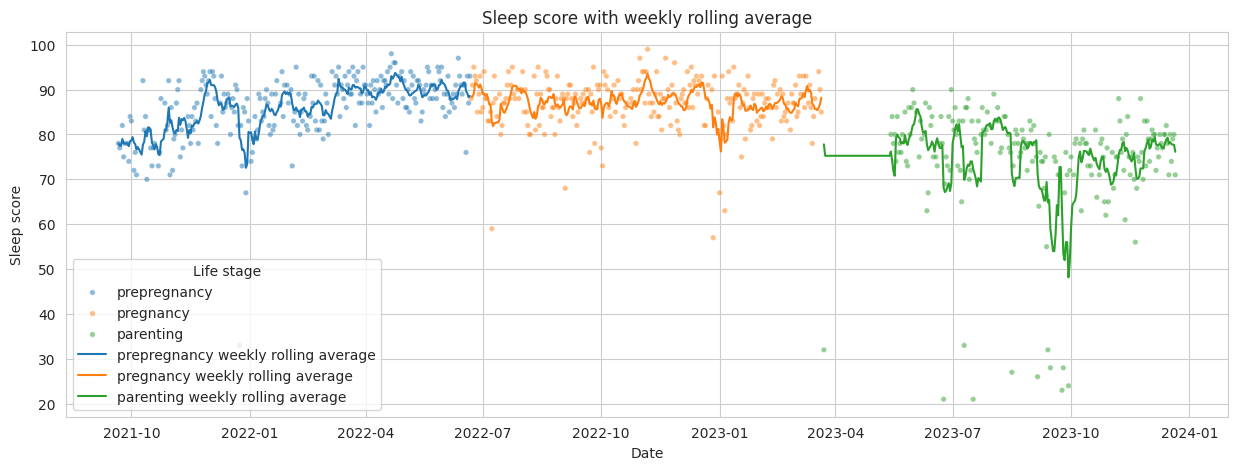

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=all_dailies_wide, x='day', y='sleep', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=all_dailies_wide, x='day', y='sleep_weekly', hue='time_tag', ax=ax)
ax.set_title("Sleep score with weekly rolling average")

ax.set_xlabel("Date")
ax.set_ylabel("Sleep score")
ax.set_title("Sleep score with weekly rolling average")

plt.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

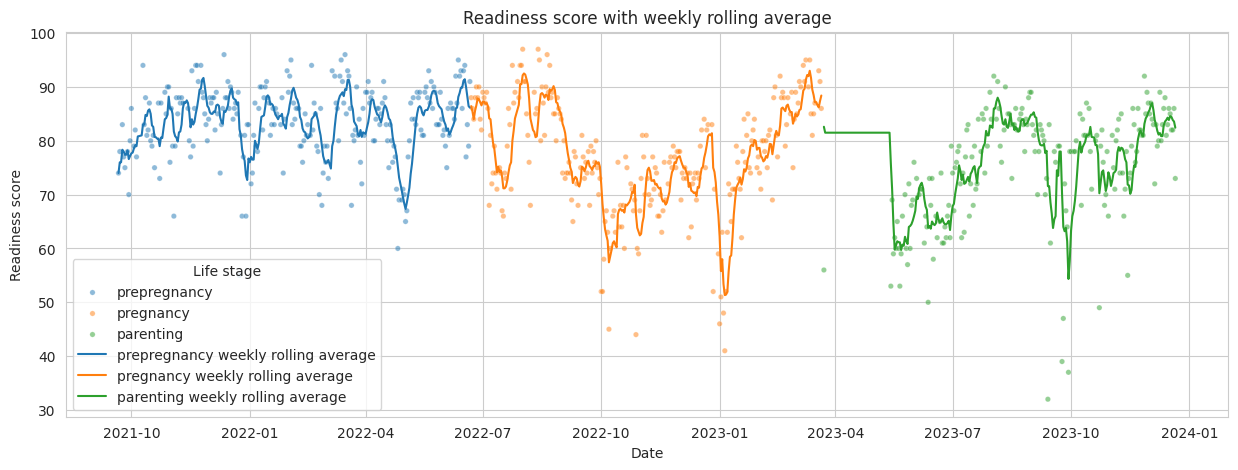

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=all_dailies_wide, x='day', y='readiness', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=all_dailies_wide, x='day', y='readiness_weekly', hue='time_tag', ax=ax)
ax.set_title("Readiness score with weekly rolling average")

ax.set_xlabel("Date")
ax.set_ylabel("Readiness score")
ax.set_title("Readiness score with weekly rolling average")

plt.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

#Sleep data

### Reading and filtering

In [ ]:
sleep = pd.read_csv(os.path.join(datadir, 'oura_sleep_2023-12-23T16-06-23.csv'))
sleep = sleep.loc[sleep.time_in_bed >= 20*60]
relevant_cols = ['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start',
                 'day', 'deep_sleep_duration', 'light_sleep_duration', 'lowest_heart_rate', 'rem_sleep_duration',
                 'restless_periods','segment_state', 'time_in_bed', 'total_sleep_duration']
sleep['bedtime_start'] = pd.to_datetime(sleep['bedtime_start'], format='%Y-%m-%d %H:%M:%S', utc=True).dt.tz_convert('Europe/Berlin')
sleep['bedtime_end'] = pd.to_datetime(sleep['bedtime_end'], format='%Y-%m-%d %H:%M:%S', utc=True).dt.tz_convert('Europe/Berlin')

sleep.day = pd.to_datetime(sleep.day, utc=True).dt.date
sleep_filtered = sleep.loc[(sleep.day >= prepregnancy.date()) & (sleep.day <= parenting.date()), relevant_cols]
sleep_filtered = sleep_filtered.loc[sleep_filtered.day.isin(sleep_dates)]
sleep_filtered

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,segment_state,time_in_bed,total_sleep_duration
589,15.875,56.84,57.0,3870.0,2021-09-21 06:20:00+02:00,2021-09-20 22:14:00+02:00,2021-09-21,8400.0,13260.0,50.0,3630.0,279.0,active,29160,25290.0
590,15.875,77.00,24.0,1440.0,2021-09-21 20:57:31+02:00,2021-09-21 20:28:31+02:00,2021-09-22,60.0,240.0,70.0,0.0,8.0,active,1740,300.0
591,16.125,59.82,45.0,4350.0,2021-09-22 06:35:29+02:00,2021-09-21 22:31:29+02:00,2021-09-22,7410.0,13050.0,54.0,4230.0,308.0,active,29040,24690.0
593,15.500,58.29,56.0,3720.0,2021-09-24 06:51:44+02:00,2021-09-23 22:03:44+02:00,2021-09-24,5940.0,17310.0,53.0,4710.0,363.0,active,31680,27960.0
594,16.000,59.64,46.0,2430.0,2021-09-25 05:35:01+02:00,2021-09-24 21:55:01+02:00,2021-09-25,4110.0,17460.0,53.0,3600.0,335.0,active,27600,25170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361,14.750,57.11,53.0,6450.0,2023-12-17 06:49:59+01:00,2023-12-16 21:27:59+01:00,2023-12-17,4620.0,16440.0,51.0,6210.0,271.0,active,33720,27270.0
2362,14.750,56.06,56.0,7012.0,2023-12-18 06:01:24+01:00,2023-12-17 21:22:02+01:00,2023-12-18,4380.0,13590.0,50.0,6180.0,181.0,active,31162,24150.0
2363,14.750,56.45,61.0,5626.0,2023-12-19 06:12:46+01:00,2023-12-18 20:59:00+01:00,2023-12-19,4440.0,16380.0,50.0,6780.0,174.0,active,33226,27600.0
2364,14.750,58.52,53.0,7578.0,2023-12-20 06:50:50+01:00,2023-12-19 21:21:02+01:00,2023-12-20,6120.0,14550.0,50.0,5940.0,242.0,active,34188,26610.0


In [ ]:
sleep_filtered["sleep_type"] = ""

bedtime_start_index = pd.DatetimeIndex(sleep_filtered['bedtime_start'])
bedtime_end_index = pd.DatetimeIndex(sleep_filtered['bedtime_end'])
night_index = np.intersect1d(
              np.union1d(bedtime_start_index.indexer_between_time('19:30','23:59'),
                         bedtime_start_index.indexer_between_time('00:00','07:00')),
              np.union1d(bedtime_end_index.indexer_between_time('19:30','23:59'),
                         bedtime_end_index.indexer_between_time('00:00','11:30')),
              )

sleep_filtered.iloc[night_index, sleep_filtered.columns.get_loc("sleep_type")] = "night"
sleep_filtered.loc[sleep_filtered.sleep_type.str.len() == 0, "sleep_type"] = "nap"
sleep_filtered.head(3)

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,segment_state,time_in_bed,total_sleep_duration,sleep_type
589,15.875,56.84,57.0,3870.0,2021-09-21 06:20:00+02:00,2021-09-20 22:14:00+02:00,2021-09-21,8400.0,13260.0,50.0,3630.0,279.0,active,29160,25290.0,night
590,15.875,77.00,24.0,1440.0,2021-09-21 20:57:31+02:00,2021-09-21 20:28:31+02:00,2021-09-22,60.0,240.0,70.0,0.0,8.0,active,1740,300.0,night
591,16.125,59.82,45.0,4350.0,2021-09-22 06:35:29+02:00,2021-09-21 22:31:29+02:00,2021-09-22,7410.0,13050.0,54.0,4230.0,308.0,active,29040,24690.0,night


#### Sanity check for naps

In [ ]:
sleep_filtered["num_naps"] = 1
sleep_aggregated = sleep_filtered.groupby(["day", "sleep_type"], as_index=False).agg({'bedtime_start':'min',
                                                   'bedtime_end': 'max',
                                                   'num_naps': 'sum',
                                                   'awake_time': 'sum',
                                                   'deep_sleep_duration': 'sum',
                                                   'light_sleep_duration': 'sum',
                                                   'rem_sleep_duration': 'sum',
                                                   'restless_periods': 'sum',
                                                   'time_in_bed': 'sum',
                                                   'total_sleep_duration': 'sum',
                                                   'lowest_heart_rate': 'min',
                                                   'average_heart_rate': 'mean',
                                                   'average_hrv': 'mean',
                                                   'average_breath': 'mean'})
sleep_aggregated['bedtime_start_time'] = sleep_aggregated.bedtime_start.dt.time
sleep_aggregated['bedtime_end_time'] = sleep_aggregated.bedtime_end.dt.time
sleep_aggregated.loc[sleep_aggregated.day <= pregnancy.date(), "time_tag"] = "prepregnancy"
sleep_aggregated.loc[(sleep_aggregated.day > pregnancy.date()) & (sleep_aggregated.day <= birthday.date()), "time_tag"] = "pregnancy"
sleep_aggregated.loc[sleep_aggregated.day > birthday.date(), "time_tag"] = "parenting"
sleep_aggregated["deep_sleep_percent"] = sleep_aggregated["deep_sleep_duration"] / sleep_aggregated["total_sleep_duration"] * 100
sleep_aggregated["rem_sleep_percent"] = sleep_aggregated["rem_sleep_duration"] / sleep_aggregated["total_sleep_duration"] * 100

In [ ]:
san = sleep_aggregated.loc[sleep_aggregated.sleep_type == 'nap' , ['bedtime_start_time', 'bedtime_end_time']].agg({
    "bedtime_start_time": ["min", "max"],
    "bedtime_end_time": ["min", "max"]
})
san

,bedtime_start_time,bedtime_end_time
min,08:13:02,09:51:00
max,19:28:59,20:16:03


In [ ]:
sleep_aggregated.loc[sleep_aggregated.day == datetime.date(2023,2,23)]

,day,sleep_type,bedtime_start,bedtime_end,num_naps,awake_time,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,...,total_sleep_duration,lowest_heart_rate,average_heart_rate,average_hrv,average_breath,bedtime_start_time,bedtime_end_time,time_tag,deep_sleep_percent,rem_sleep_percent
698,2023-02-23,nap,2023-02-23 15:31:02+01:00,2023-02-23 17:28:02+01:00,2,4170.0,630.0,510.0,30.0,23.0,...,1170.0,71.0,76.625,19.5,14.875,15:31:02,17:28:02,pregnancy,53.846154,2.564103
699,2023-02-23,night,2023-02-22 21:54:41+01:00,2023-02-23 11:02:41+01:00,1,13470.0,3990.0,14940.0,14880.0,184.0,...,33810.0,68.0,76.910,17.0,14.875,21:54:41,11:02:41,pregnancy,11.801242,44.010648


In [ ]:
sani = sleep_aggregated.loc[sleep_aggregated.sleep_type == 'night' , ['bedtime_start_time', 'bedtime_end_time']].agg({
    "bedtime_start_time": ["min", "max"],
    "bedtime_end_time": ["min", "max"]
})
sani

,bedtime_start_time,bedtime_end_time
min,00:03:30,04:04:39
max,23:48:15,22:18:32


In [ ]:
sleep_aggregated.loc[sleep_aggregated.bedtime_end_time == sani.loc["max", "bedtime_end_time"]]
sleep.loc[sleep.day == datetime.date(2023, 3, 24)]

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
1957,15.25,71.8,28.0,810.0,2023-03-23 22:39:03+01:00,2023-03-23 22:10:03+01:00,2023-03-24,210.0,53.0,360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Have I started napping more?

In [ ]:
naps_pvt = pd.pivot_table(data = sleep_aggregated,
                          index='day',
                          columns='sleep_type',
                          values='num_naps',
                          fill_value=0,
                          aggfunc='sum')
naps_pvt.loc[naps_pvt.nap >= 1, "nap"] = 1
naps_pvt.loc[naps_pvt.index <= pregnancy.date(), "time_tag"] = "prepregnancy"
naps_pvt.loc[(naps_pvt.index > pregnancy.date()) & (naps_pvt.index <= birthday.date()), "time_tag"] = "pregnancy"
naps_pvt.loc[naps_pvt.index > birthday.date(), "time_tag"] = "parenting"
naps_pvt.groupby("time_tag").agg({"nap": ["mean", "sum", "count"]})

sleep_type         nap           
                  mean  sum count
time_tag                         
parenting     0.407035   81   199
pregnancy     0.612000  153   250
prepregnancy  0.357430   89   249

### Wake-up and go-to-bed times

In [ ]:
def num2time(n: int):
  hrs = int(n // 3600)
  if hrs >= 24:
    hrs -= 24
  min = int((n % 3600) // 60)
  sec = int((n % 3600) % 60)
  return f'{hrs:02d}:{min:02d}'

def time2num(t):
  n = t.hour * 3600 + t.minute * 60 + t.second
  if t.hour <= 3:
    n += 24*3600
  return n

In [ ]:
night_sleep_wide = sleep_aggregated.loc[sleep_aggregated.sleep_type == "night", ["bedtime_start_time", "bedtime_end_time", "day", "time_tag"]].copy()
night_sleep = pd.melt(night_sleep_wide,
                      id_vars = ["day", "time_tag"],
                      value_vars = ["bedtime_start_time", "bedtime_end_time"],
                      var_name = "bedtime_type",
                      value_name = "bedtime")
night_sleep.head(3)

,day,time_tag,bedtime_type,bedtime
0,2021-09-21,prepregnancy,bedtime_start_time,22:14:00
1,2021-09-22,prepregnancy,bedtime_start_time,20:28:31
2,2021-09-24,prepregnancy,bedtime_start_time,22:03:44


In [ ]:
night_sleep_wide.loc[night_sleep_wide.bedtime_end_time > datetime.time(15,0,0)]

,bedtime_start_time,bedtime_end_time,day,time_tag
96,21:10:32,22:18:32,2021-12-24,prepregnancy
926,19:56:01,20:43:01,2023-09-29,parenting


In [ ]:
all_dailies.loc[all_dailies.day == datetime.date(2023, 9, 29)]

,score,day,var_type,time_tag,daynum
919,37,2023-09-29,readiness,parenting,19629.0
919,24,2023-09-29,sleep,parenting,19629.0
1004,90,2023-09-29,activity,parenting,19629.0


In [ ]:
night_sleep_wide.loc[night_sleep_wide.bedtime_start_time <= datetime.time(6, 0, 0)]

,bedtime_start_time,bedtime_end_time,day,time_tag
611,03:06:02,09:43:02,2023-01-01,pregnancy
612,00:03:30,07:27:30,2023-01-02,pregnancy
618,00:09:38,08:10:38,2023-01-05,pregnancy


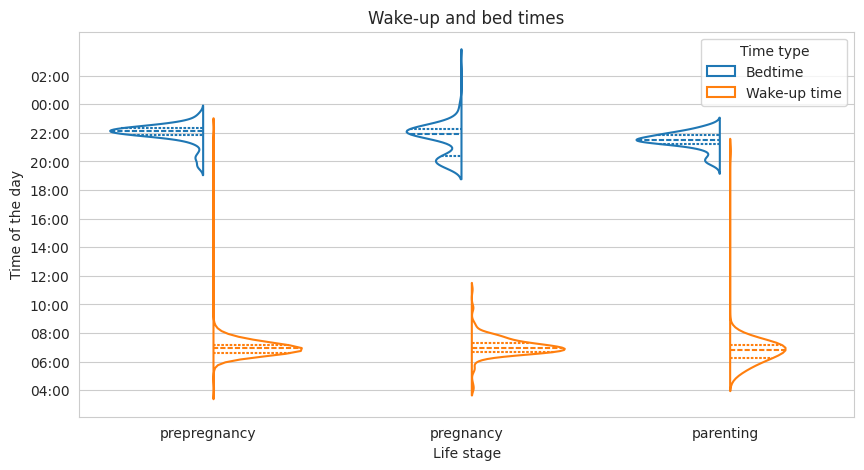

In [ ]:
night_sleep["bedtime_num"] = night_sleep["bedtime"].apply(time2num)
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.violinplot(data=night_sleep, x="time_tag", y="bedtime_num", hue="bedtime_type", split=True, gap=0.1, inner='quart', fill=False)#, cut=1, bw_method=0.5)
labels = [time2num(datetime.time(x, 0, 0)) for x in list(range(4, 24, 2))]  + [x*3600 for x in [24, 26]] # ax.get_yticks() # get x labels
new_labels = [num2time(label) for label in labels] # convert ordinal back to datetime
ax.set_ylabel("Time of the day")
ax.set_xlabel("Life stage")
ax.set_yticks(labels)
ax.set_yticklabels(new_labels, rotation=0) # set new labels
ax.set_title("Wake-up and bed times")

plt.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title("Time type")
new_labels = ["Bedtime", "Wake-up time"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.show()

### Rem and Deep sleep percentages

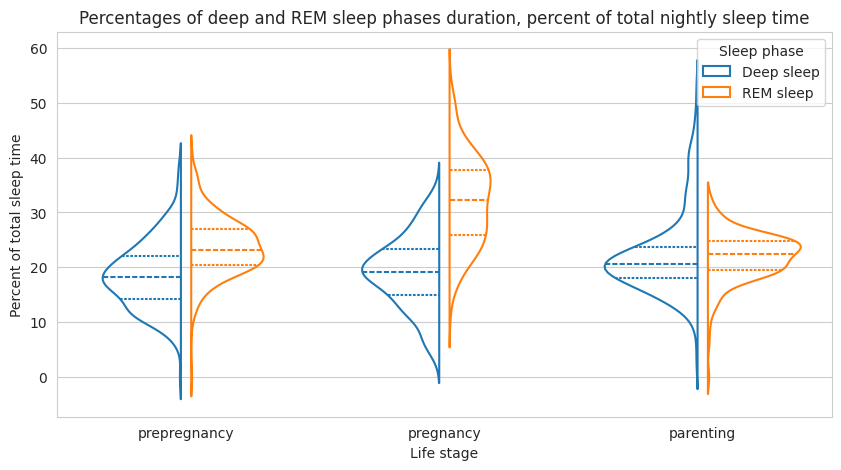

In [ ]:
rem_deep_wide = sleep_aggregated.loc[sleep_aggregated.sleep_type == "night", ["rem_sleep_percent", "deep_sleep_percent", "day", "time_tag"]].copy()
rem_deep = pd.melt(rem_deep_wide,
                      id_vars = ["day", "time_tag"],
                      value_vars = ["rem_sleep_percent", "deep_sleep_percent"],
                      var_name = "sleep_type",
                      value_name = "sleep_percent")
fig, ax = plt.subplots(figsize=(10, 5))
p1 = sns.violinplot(data=rem_deep, x="time_tag", y="sleep_percent", inner='quart', hue="sleep_type", hue_order=["deep_sleep_percent", "rem_sleep_percent"],
               gap=0.1, split=True, fill=False)
ax.set_title("Percentages of deep and REM sleep phases duration, percent of total nightly sleep time")

ax.set_xlabel("Life stage")
ax.set_ylabel("Percent of total sleep time")

plt.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title("Sleep phase")
new_labels = ['Deep sleep', 'REM sleep']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

### Total duration, heart rate and HRV

In [ ]:
sleep_night = sleep_aggregated.loc[sleep_aggregated.sleep_type == "night", ["lowest_heart_rate", "average_hrv", "total_sleep_duration", "day", "time_tag"]].copy()

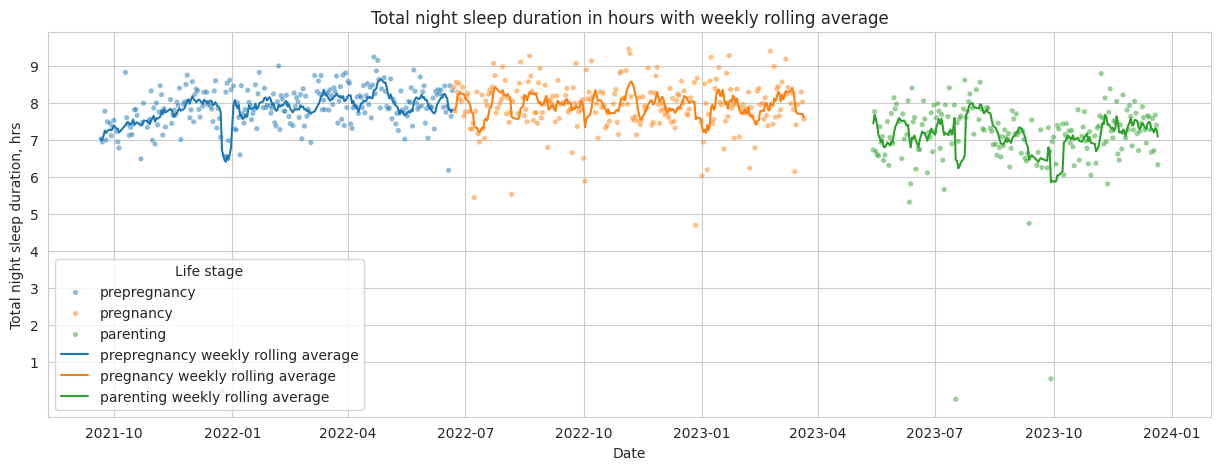

In [ ]:
sleep_night["total_duration_weekly"] = sleep_night["total_sleep_duration"].rolling(7, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=sleep_night, x='day', y='total_sleep_duration', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=sleep_night, x='day', y='total_duration_weekly', hue='time_tag', ax=ax)

new_ylabels = list(range(1, 10))
ax.set_yticks([x*3600 for x in new_ylabels])
ax.set_yticklabels(new_ylabels)
ax.set_title("Total night sleep duration in hours with weekly rolling average")

ax.set_xlabel("Date")
ax.set_ylabel("Total night sleep duration, hrs")

plt.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

Text(0.5, 1.0, 'Resting heart rate in bpm with weekly rolling average')

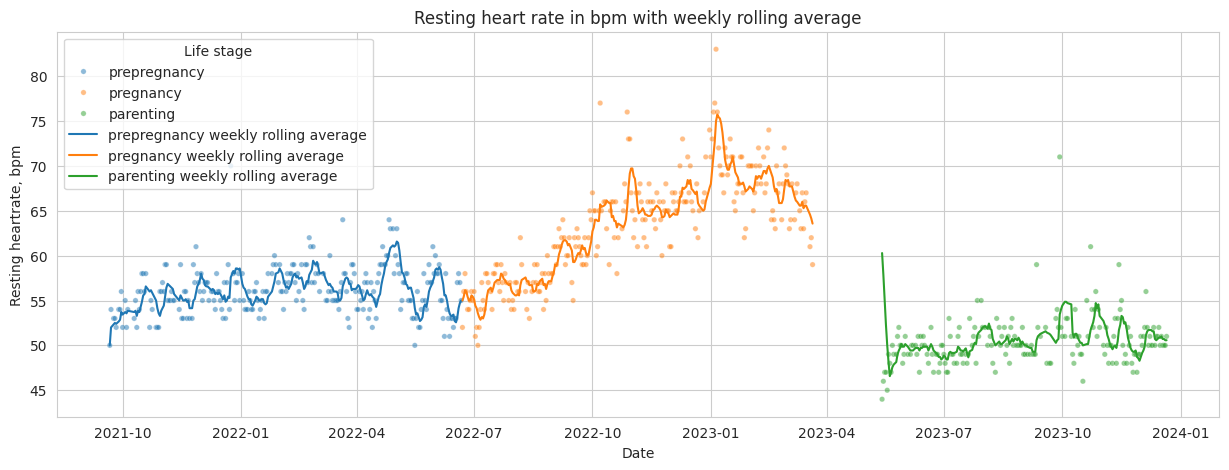

In [ ]:
sleep_night["lowest_heart_rate_weekly"] = sleep_night["lowest_heart_rate"].rolling(7, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=sleep_night, x='day', y='lowest_heart_rate', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=sleep_night, x='day', y='lowest_heart_rate_weekly', hue='time_tag', ax=ax)


ax.set_xlabel("Date")
ax.set_ylabel("Resting heartrate, bpm")

plt.legend(loc='upper left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
ax.set_title("Resting heart rate in bpm with weekly rolling average")

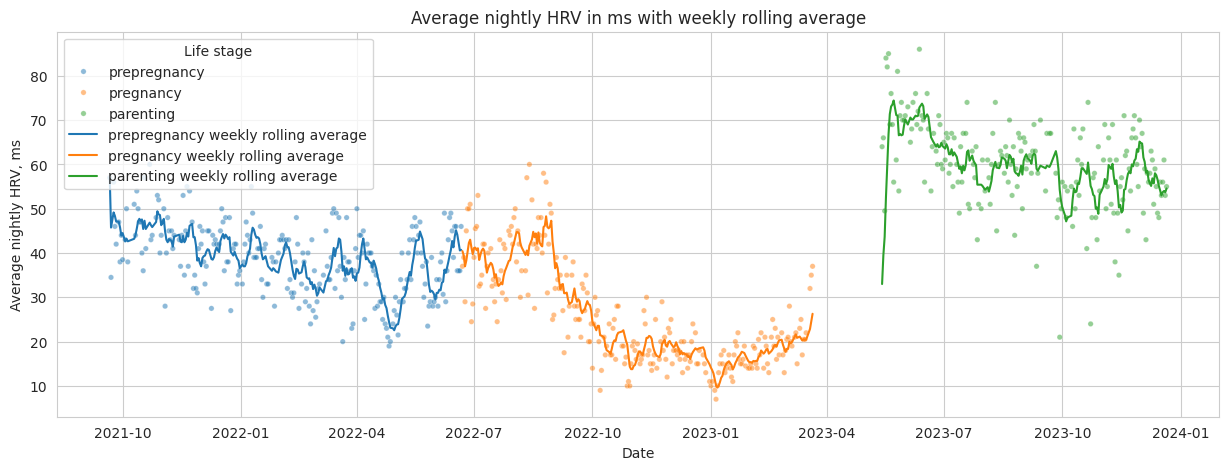

In [ ]:
sleep_night["average_hrv_weekly"] = sleep_night["average_hrv"].rolling(7, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(15, 5))
p1 = sns.scatterplot(data=sleep_night, x='day', y='average_hrv', ax=ax, alpha=0.5, s=15, hue='time_tag')
p2 = sns.lineplot(data=sleep_night, x='day', y='average_hrv_weekly', hue='time_tag', ax=ax)
ax.set_title("Average nightly HRV in ms with weekly rolling average")

ax.set_xlabel("Date")
ax.set_ylabel("Average nightly HRV, ms")

plt.legend(loc='upper left')
leg = ax.get_legend()
leg.set_title("Life stage")
new_labels = ['prepregnancy', 'pregnancy', 'parenting', 'prepregnancy weekly rolling average', 'pregnancy weekly rolling average', 'parenting weekly rolling average']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)